# Pre

In [1]:
%matplotlib inline
import numpy as np
import _tpg.tpg as tp
import matplotlib.pyplot as plt
import os
import gym
import random
from _tpg.utils import *
from datetime import datetime

In [2]:
def log_load(title , task, renge, _step=5):
    l =[]

    with open(f"{title}.log", "r") as file:
        lines = file.readlines()
        for line in lines:
            results = line.replace('\n','').split(', ')[2:]
            # breakpoint(results)
            if len(results)<2: continue
            if f'{task}' in results[0] and 'generation:' in results[1]:
                l.append([float(re.split(':')[1]) for re in results[2:]])
                end = int(results[1].split(':')[1])

    __min = []
    __mi = 0.
    __max = []
    __ma = 0.
    __ave = []
    __av = 0.
    for i, item in enumerate(l):
        _min, _max, _ave = item
        __mi+=_min
        __ma+=_max
        __av+=_ave
        # if i==0: continue
        if i%_step==_step-1:
            __min.append(__mi/float(_step))
            __mi=0.
            __max.append(__ma/float(_step))
            __ma=0.
            __ave.append(__av/float(_step))
            __av=0.
        if i == renge: break
    mi = np.array(__min)
    ma = np.array(__max)
    av = np.array(__ave)
    
    return mi, ma, av, end

In [3]:
def log_accumlation(title, task, _renge=100, _step=5):
    l =[]

    with open(f"{title}.log", "r") as file:
        lines = file.readlines()
        for line in lines:
            results = line.replace('\n','').split(', ')[2:]
            # breakpoint(results)
            if len(results)<2: continue
            if (f'{task}' in results[0] or f'{task}' == 'any') and 'generation:' in results[1]:
                l.append([float(re.split(':')[1]) for re in results[2:]])
                end = int(results[1].split(':')[1])

    __min = [0.]
    __mi = 0.
    __max = [0.]
    __ma = 0.
    __ave = [0.]
    __av = 0.
    for i, item in enumerate(l):
        _min, _max, _ave = item
        __mi+=_min
        __ma+=_max
        __av+=_ave
        # if i==0: continue
        if i%_step==_step-1:
            __mi/=float(_step)
            __mi+=__min[-1]
            __min.append(__mi)
            __mi=0.
            __ma/=float(_step)
            __ma+=__max[-1]
            __max.append(__ma)
            __ma=0.
            __av/=float(_step)
            __av+=__ave[-1]
            __ave.append(__av)
            __av=0.
        if i == _renge: break

    mi = np.array(__min)
    ma = np.array(__max)
    av = np.array(__ave)
    
    return mi, ma, av, end


In [4]:
def log_elite(title, _scores):
    with open(f"{title}.log", "r") as file:
        lines = file.readlines()
        for line in lines:
            results = line.replace('\n','').split(', ')[2:]
            # breakpoint(results)
            if len(results)<3: continue
            if 'task:' in results[0] and 'elite_score:' in results[2]:
                if not _scores.get(results[0].split(':')[1]): _scores[results[0].split(':')[1]]=0.
                _scores[results[0].split(':')[1]]+=float(results[2].split(':')[1])
    return _scores

In [5]:
def log_elite_std(title, _scores):
    with open(f"{title}.log", "r") as file:
        lines = file.readlines()
        for line in lines:
            results = line.replace('\n','').split(', ')[2:]
            # breakpoint(results)
            if len(results)<3: continue
            if 'task:' in results[0] and 'elite_score:' in results[2]:
                if not _scores.get(results[0].split(':')[1]): _scores[results[0].split(':')[1]]=[]
                _scores[results[0].split(':')[1]].append(float(results[2].split(':')[1]))
    return _scores

In [6]:
def log_normalize(title, _min_type='ave', _max_type='ave'):
    _normalize = [0.,0.]
    with open(f"{title}.txt", "r") as file:
        lines = file.readlines()
        _results = lines[0].replace('\n','').split(', ')
        for _result in _results:
            if f'min-{_min_type}:' in _result: _normalize[0]=float(_result.split(':')[1])
            if f'max-{_max_type}:' in _result: _normalize[1]=float(_result.split(':')[1])

    return _normalize


In [7]:
def test_multi_elite(tpg, _title=None):
    """ マルチタスク学習に対応できるように、改良。
    """
    tasks=[]
    archive = []

    if os.path.exists('./.tasks'):
        with open('./.tasks', 'r') as task_file:
            tasks = task_file.read().splitlines()
            random.seed(datetime.now().strftime('%Y%m%d%H%M%S'))
            random.shuffle(tasks)
    else:
        raise Exception('tasksDoesntExist')

    if _title:
        if os.path.exists(f'{_title}.pickle'):
            tpg.load_story(_title)
        else:
            raise Exception('titleDoesntExist', repr(_title))
    
    try:
        for task in tasks:
            title = tpg.success_story(_task=task)
            archive.append(title)
    except Exception as e:
        print(e)
        # os.remove('./tasks.txt')
    return archive


# chaos

### TPG

In [137]:
prefix = '../../../Downloads/2022-12-08/'
files = [
    f'{prefix}20-15-55',
    f'{prefix}20-24-49',
    f'{prefix}20-33-22',
    f'{prefix}20-40-42',
    f'{prefix}20-49-53',
    f'{prefix}20-57-54',
    f'{prefix}21-06-35',
    f'{prefix}21-14-43',
    f'{prefix}21-21-27',
    f'{prefix}21-29-11'
]
renge=100
step=5
ends = (renge//step)

mi = np.zeros(ends+1)
ma = np.zeros(ends+1)
av = np.zeros(ends+1)
end=0
for file in files:
    _mi, _ma, _av, end = log_accumlation(file,'any', _renge=renge, _step=step)
    assert _mi.size==mi.size, f'{file} {_mi.size} dont match'
    mi=np.add(mi,_mi)
    ma=np.add(ma,_ma)
    av=np.add(av,_av)
mi_tpg=np.divide(mi,10)
ma_tpg=np.divide(ma,10)
av_tpg=np.divide(av,10)

### MHTPG

In [142]:
prefix = '../../../Downloads/test/'
files = [
    f'{prefix}2022-12-04/22-12-45',
    f'{prefix}2022-12-05/10-02-26',
    f'{prefix}2022-12-05/10-26-46',
    f'{prefix}2022-12-05/10-56-46',
    f'{prefix}2022-12-05/11-20-13',
    f'{prefix}2022-12-05/11-48-00',
    f'{prefix}2022-12-05/12-19-21',
    f'{prefix}2022-12-05/12-40-11',
    f'{prefix}2022-12-05/13-06-28',
    f'{prefix}2022-12-05/13-30-22'
]
renge=100
step=5
ends = (renge//step)

mi = np.zeros(ends+1)
ma = np.zeros(ends+1)
av = np.zeros(ends+1)
end=0
for file in files:
    _mi, _ma, _av, end = log_accumlation(file,'any', _renge=renge, _step=step)
    assert _mi.size==mi.size, f'{file} {_mi.size} dont match'
    mi=np.add(mi,_mi)
    ma=np.add(ma,_ma)
    av=np.add(av,_av)
mi_tpg_mh=np.divide(mi,10)
ma_tpg_mh=np.divide(ma,10)
av_tpg_mh=np.divide(av,10)

### Actor1

In [146]:
prefix = 'log/test/'
files = [
    f'{prefix}2022-12-05/07-20-22',
    f'{prefix}2022-12-05/10-03-30',
    f'{prefix}2022-12-05/10-21-47',
    f'{prefix}2022-12-05/10-41-03',
    f'{prefix}2022-12-05/11-00-45',
    f'{prefix}2022-12-05/11-18-39',
    f'{prefix}2022-12-05/11-35-38',
    f'{prefix}2022-12-05/11-55-13',
    f'{prefix}2022-12-05/12-16-18',
    f'{prefix}2022-12-05/12-36-15',
]
renge=100
step=5
ends = (renge//step)

mi = np.zeros(ends+1)
ma = np.zeros(ends+1)
av = np.zeros(ends+1)
end=0
for file in files:
    _mi, _ma, _av, end = log_accumlation(file,'any', _renge=renge, _step=step)
    assert _mi.size==mi.size, f'{file} {_mi.size} dont match'
    mi=np.add(mi,_mi)
    ma=np.add(ma,_ma)
    av=np.add(av,_av)
mi_tpg_actor1=np.divide(mi,10)
ma_tpg_actor1=np.divide(ma,10)
av_tpg_actor1=np.divide(av,10)

### Actor2

In [ ]:
prefix = 'log/test/'
files = [
    f'{prefix}2022-12-06/21-31-59',
    f'{prefix}2022-12-06/21-50-01',
    f'{prefix}2022-12-06/22-10-50',
    f'{prefix}2022-12-06/22-28-11',
    f'{prefix}2022-12-06/22-50-55',
    f'{prefix}2022-12-06/23-08-05',
    f'{prefix}2022-12-06/23-25-26',
    f'{prefix}2022-12-06/23-51-32',
    f'{prefix}2022-12-07/00-08-46',
    f'{prefix}2022-12-07/00-24-57',
]

In [147]:
prefix = './log/test/'
titles = [
    f'{prefix}2022-12-11/20-31-05',
    f'{prefix}2022-12-11/20-48-58',
    f'{prefix}2022-12-11/21-10-33',
    f'{prefix}2022-12-11/21-29-29',
    f'{prefix}2022-12-11/21-48-54',
    f'{prefix}2022-12-12/10-27-21',
    f'{prefix}2022-12-12/10-47-36',
    f'{prefix}2022-12-12/11-04-20',
    f'{prefix}2022-12-12/11-22-11',
    f'{prefix}2022-12-12/11-40-07'
]
renge=100
step=5
ends = (renge//step)

mi = np.zeros(ends+1)
ma = np.zeros(ends+1)
av = np.zeros(ends+1)
end=0
for file in files:
    _mi, _ma, _av, end = log_accumlation(file,'any', _renge=renge, _step=step)
    assert _mi.size==mi.size, f'{file} {_mi.size} dont match'
    mi=np.add(mi,_mi)
    ma=np.add(ma,_ma)
    av=np.add(av,_av)
mi_tpg_actor2=np.divide(mi,10)
ma_tpg_actor2=np.divide(ma,10)
av_tpg_actor2=np.divide(av,10)

### Show

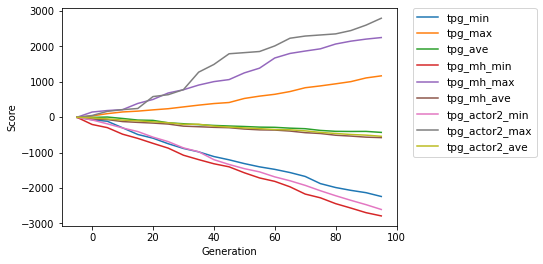

In [149]:
renge=100
step=5
ends = (renge//step)

ge = np.arange((ends-mi.size)*step, ends*step, step)

plt.plot(ge, mi_tpg, label='tpg_min')
plt.plot(ge, ma_tpg, label='tpg_max')
plt.plot(ge, av_tpg, label='tpg_ave')
plt.plot(ge, mi_tpg_mh, label='tpg_mh_min')
plt.plot(ge, ma_tpg_mh, label='tpg_mh_max')
plt.plot(ge, av_tpg_mh, label='tpg_mh_ave')
plt.plot(ge, mi_tpg_actor2, label='tpg_actor2_min')
plt.plot(ge, ma_tpg_actor2, label='tpg_actor2_max')
plt.plot(ge, av_tpg_actor2, label='tpg_actor2_ave')

plt.ylabel('Score')
plt.xlabel('Generation')
# plt.legend()
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=10.5)
plt.show()

# single each

### TPG

#### ALE/Pitfall-ram-v5

In [193]:
prefix = '../../../Downloads/test/'
files = [
    f'{prefix}2022-12-06/00-27-30',
    f'{prefix}2022-12-06/01-13-37',
    f'{prefix}2022-12-05/18-12-27',
    f'{prefix}2022-12-05/18-55-45',
    f'{prefix}2022-12-05/19-43-00',
    f'{prefix}2022-12-05/20-32-31',
    f'{prefix}2022-12-05/21-21-33',
    f'{prefix}2022-12-05/22-10-14',
    f'{prefix}2022-12-05/22-54-57',
    f'{prefix}2022-12-05/23-40-53'
]
task="ALE/Pitfall-ram-v5"

#### SpaceInvaders-v0

In [194]:
prefix = '../../../Downloads/test/'
files = [
    f'{prefix}2022-12-06/00-32-30',
    f'{prefix}2022-12-06/01-18-41',
    f'{prefix}2022-12-05/18-16-57',
    f'{prefix}2022-12-05/19-00-08',
    f'{prefix}2022-12-05/19-48-13',
    f'{prefix}2022-12-05/20-37-43',
    f'{prefix}2022-12-05/21-26-49',
    f'{prefix}2022-12-05/22-15-06',
    f'{prefix}2022-12-05/22-59-12',
    f'{prefix}2022-12-05/23-45-09'
]
task="SpaceInvaders-v0"


#### Hero-ramDeterministic-v4

In [195]:
prefix = '../../../Downloads/test/'
files = [
    f'{prefix}2022-12-06/00-11-55',
    f'{prefix}2022-12-06/00-58-12',
    f'{prefix}2022-12-06/01-42-18',
    f'{prefix}2022-12-05/18-40-53',
    f'{prefix}2022-12-05/19-26-12',
    f'{prefix}2022-12-05/20-14-39',
    f'{prefix}2022-12-05/21-02-29',
    f'{prefix}2022-12-05/21-52-21',
    f'{prefix}2022-12-05/22-39-00',
    f'{prefix}2022-12-05/23-23-55'
]
task="Hero-ramDeterministic-v4"

#### MontezumaRevengeDeterministic-v0

In [196]:
prefix = '../../../Downloads/test/'
files = [
    f'{prefix}2022-12-06/00-42-45',
    f'{prefix}2022-12-06/01-28-22',
    f'{prefix}2022-12-05/18-27-30',
    f'{prefix}2022-12-05/19-10-51',
    f'{prefix}2022-12-05/19-59-25',
    f'{prefix}2022-12-05/20-47-27',
    f'{prefix}2022-12-05/21-36-45',
    f'{prefix}2022-12-05/22-25-28',
    f'{prefix}2022-12-05/23-08-50',
    f'{prefix}2022-12-05/23-55-52'
]
task="MontezumaRevengeDeterministic-v0"


#### Hero-v4

In [197]:
prefix = '../../../Downloads/test/'
files = [
    f'{prefix}2022-12-06/00-00-25',
    f'{prefix}2022-12-06/00-46-24',
    f'{prefix}2022-12-06/01-31-23',
    f'{prefix}2022-12-05/18-30-02',
    f'{prefix}2022-12-05/19-14-45',
    f'{prefix}2022-12-05/20-03-36',
    f'{prefix}2022-12-05/20-50-41',
    f'{prefix}2022-12-05/21-42-13',
    f'{prefix}2022-12-05/22-28-36',
    f'{prefix}2022-12-05/23-12-35'
]
task="Hero-v4"


#### PrivateEye-ramDeterministic-v0

In [198]:
prefix = '../../../Downloads/test/'
files = [
    f'{prefix}2022-12-06/00-37-30',
    f'{prefix}2022-12-06/01-23-24',
    f'{prefix}2022-12-05/18-22-02',
    f'{prefix}2022-12-05/19-04-50',
    f'{prefix}2022-12-05/19-53-40',
    f'{prefix}2022-12-05/20-42-27',
    f'{prefix}2022-12-05/21-30-50',
    f'{prefix}2022-12-05/22-20-03',
    f'{prefix}2022-12-05/23-03-47',
    f'{prefix}2022-12-05/23-49-02'
]
task="PrivateEye-ramDeterministic-v0"


#### ALE/Jamesbond-ram-v5

In [199]:
prefix = '/Users/matsuzawakazuki/Downloads/test/'
files = [
    f'{prefix}2022-12-06/00-19-22',
    f'{prefix}2022-12-06/01-06-06',
    f'{prefix}2022-12-06/01-49-49',
    f'{prefix}2022-12-05/18-47-53',
    f'{prefix}2022-12-05/19-34-28',
    f'{prefix}2022-12-05/20-22-35',
    f'{prefix}2022-12-05/21-10-58',
    f'{prefix}2022-12-05/22-00-52',
    f'{prefix}2022-12-05/22-45-37',
    f'{prefix}2022-12-05/23-32-06'
]
task="ALE/Jamesbond-ram-v5"


#### ALE/WizardOfWor-v5

In [200]:
prefix = '../../../Downloads/test/'
files = [
    f'{prefix}2022-12-06/00-23-08',
    f'{prefix}2022-12-06/01-09-33',
    f'{prefix}2022-12-06/01-54-12',
    f'{prefix}2022-12-05/18-50-59',
    f'{prefix}2022-12-05/19-38-05',
    f'{prefix}2022-12-05/20-26-57',
    f'{prefix}2022-12-05/21-16-27',
    f'{prefix}2022-12-05/22-04-56',
    f'{prefix}2022-12-05/22-49-14',
    f'{prefix}2022-12-05/23-35-35'
]
task="ALE/WizardOfWor-v5"


#### DoubleDunk-ramNoFrameskip-v4

In [201]:
prefix = '../../../Downloads/test/'
files = [
    f'{prefix}2022-12-06/00-16-51',
    f'{prefix}2022-12-06/01-04-15',
    f'{prefix}2022-12-06/01-47-30',
    f'{prefix}2022-12-05/18-46-02',
    f'{prefix}2022-12-05/19-32-14',
    f'{prefix}2022-12-05/20-20-28',
    f'{prefix}2022-12-05/21-08-43',
    f'{prefix}2022-12-05/21-57-55',
    f'{prefix}2022-12-05/22-43-21',
    f'{prefix}2022-12-05/23-29-18'
]
task="DoubleDunk-ramNoFrameskip-v4"


#### PitfallDeterministic-v4

In [202]:
prefix = '../../../Downloads/test/'
files = [
    f'{prefix}2022-12-06/00-05-48',
    f'{prefix}2022-12-06/00-51-54',
    f'{prefix}2022-12-06/01-36-39',
    f'{prefix}2022-12-05/18-35-06',
    f'{prefix}2022-12-05/19-20-43',
    f'{prefix}2022-12-05/20-08-39',
    f'{prefix}2022-12-05/20-55-44',
    f'{prefix}2022-12-05/21-47-05',
    f'{prefix}2022-12-05/22-33-58',
    f'{prefix}2022-12-05/23-17-36'
]
task="PitfallDeterministic-v4"


#### CartPole-v1

In [15]:
prefix = './log/CartPole-v1/2022-12-16/'
files = [
    f'{prefix}15-50-24',
    f'{prefix}15-52-28',
    f'{prefix}15-51-38',
    f'{prefix}15-49-24',
    f'{prefix}15-41-44',
    f'{prefix}15-50-14',
    f'{prefix}15-47-53',
    f'{prefix}15-40-36',
    f'{prefix}15-46-45',
    f'{prefix}15-45-24'
]
task="CartPole-v1"

#### Show

1.273624060150375


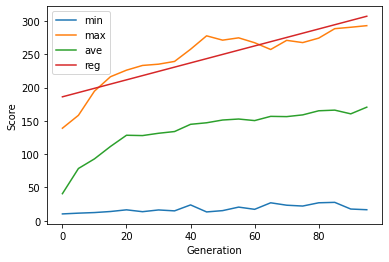

129.906


In [16]:
renge=100
step=5
ends = (renge//step)

mi = np.zeros(ends)
ma = np.zeros(ends)
av = np.zeros(ends)
end=0
for file in files:
    _mi, _ma, _av, end = log_load(file,task, renge=renge, _step=step)
    assert _mi.size==mi.size, f'{file} {_mi.size} dont match'
    mi=np.add(mi,_mi)
    ma=np.add(ma,_ma)
    av=np.add(av,_av)
mi=np.divide(mi,10)
ma=np.divide(ma,10)
av=np.divide(av,10)
ge = np.arange((ends-mi.size)*step, ends*step, step)

a,b=np.polyfit(ge,ma,1)
fh=a*ge+b
print(a,b)
title = f"./results/tpg-{task.replace('/','-')}"
plt.plot(ge, mi, label='min')
plt.plot(ge, ma, label='max')
plt.plot(ge, av, label='ave')
plt.plot(ge, fh, label='reg')

plt.ylabel('Score')
plt.xlabel('Generation')
plt.legend()
plt.savefig(f"{title}.png")
plt.show()
with open(f'{title}.txt','w') as f:
    f.write(f'min-min:{min(mi)}, max-min:{min(ma)}, ave-min:{min(av)}, min-max:{max(mi)}, max-max:{max(ma)}, ave-max:{max(av)}, min-ave:{sum(mi)/len(mi)}, max-ave:{sum(ma)/len(ma)}, ave-ave:{sum(av)/len(av)}, fh-a:{a}, fh-b:{b}')
print(av[-1]-av[0])

### MHTPG

#### ALE/Jamesbond-ram-v5

In [407]:
prefix = '../../../Downloads/test/'
files = [
    f'{prefix}2022-12-01/15-21-35',
    f'{prefix}2022-12-01/17-53-45',
    f'{prefix}2022-12-01/19-37-35',
    f'{prefix}2022-12-01/21-47-14',
    f'{prefix}2022-12-01/23-54-38',
    f'{prefix}2022-12-02/02-21-42',
    f'{prefix}2022-12-02/05-11-35',
    f'{prefix}2022-12-02/07-28-27',
    f'{prefix}2022-12-02/09-54-26',
    f'{prefix}2022-12-02/11-55-50'
]
task="ALE/Jamesbond-ram-v5"

#### ALE/Pitfall-ram-v5

In [409]:
prefix = '../../../Downloads/test/'
files = [
    f'{prefix}2022-12-01/17-07-42',
    f'{prefix}2022-12-01/18-03-36',
    f'{prefix}2022-12-01/19-48-26',
    f'{prefix}2022-12-01/21-56-07',
    f'{prefix}2022-12-02/00-12-18',
    f'{prefix}2022-12-02/02-34-31',
    f'{prefix}2022-12-02/05-28-13',
    f'{prefix}2022-12-02/07-36-27',
    f'{prefix}2022-12-02/10-05-33',
    f'{prefix}2022-12-02/12-04-18'
]
task="ALE/Pitfall-ram-v5"

#### ALE/WizardOfWor-v5

In [411]:
prefix = '../../../Downloads/test/'
files = [
    f'{prefix}2022-12-01/15-36-21',
    f'{prefix}2022-12-01/18-21-17',
    f'{prefix}2022-12-01/19-58-06',
    f'{prefix}2022-12-01/22-12-25',
    f'{prefix}2022-12-02/00-28-29',
    f'{prefix}2022-12-02/02-51-40',
    f'{prefix}2022-12-02/05-48-46',
    f'{prefix}2022-12-02/07-52-39',
    f'{prefix}2022-12-02/10-21-19',
    f'{prefix}2022-12-02/12-15-11'
]
task="ALE/WizardOfWor-v5"

#### DoubleDunk-ramNoFrameskip-v4

In [414]:
prefix = '../../../Downloads/test/'
files = [
    f'{prefix}2022-12-01/16-53-49',
    f'{prefix}2022-12-01/17-06-43',
    f'{prefix}2022-12-01/18-54-00',
    f'{prefix}2022-12-01/20-53-27',
    f'{prefix}2022-12-01/23-05-33',
    f'{prefix}2022-12-02/01-15-23',
    f'{prefix}2022-12-02/03-44-09',
    f'{prefix}2022-12-02/06-41-08',
    f'{prefix}2022-12-02/08-59-55',
    f'{prefix}2022-12-02/11-09-28'
]
task="DoubleDunk-ramNoFrameskip-v4"

#### Hero-ramDeterministic-v4

In [416]:
prefix = '../../../Downloads/test/'
files = [
    f'{prefix}2022-12-01/17-13-58',
    f'{prefix}2022-12-01/17-21-16',
    f'{prefix}2022-12-01/19-02-20',
    f'{prefix}2022-12-01/21-06-14',
    f'{prefix}2022-12-01/23-10-13',
    f'{prefix}2022-12-02/01-33-13',
    f'{prefix}2022-12-02/03-59-50',
    f'{prefix}2022-12-02/06-48-13',
    f'{prefix}2022-12-02/09-08-15',
    f'{prefix}2022-12-02/11-19-51'
]
task="Hero-ramDeterministic-v4"

#### Hero-v4

In [418]:
prefix = '../../../Downloads/test/'
files = [
    f'{prefix}2022-12-01/16-37-46',
    f'{prefix}2022-12-01/17-40-20',
    f'{prefix}2022-12-01/19-26-00',
    f'{prefix}2022-12-01/21-32-29',
    f'{prefix}2022-12-01/23-38-38',
    f'{prefix}2022-12-02/02-08-38',
    f'{prefix}2022-12-02/04-48-27',
    f'{prefix}2022-12-02/07-12-09',
    f'{prefix}2022-12-02/09-44-26',
    f'{prefix}2022-12-02/11-42-35'
]
task="Hero-v4"

#### MontezumaRevengeDeterministic-v0

In [420]:
prefix = '../../../Downloads/test/'
files = [
    f'{prefix}2022-12-01/16-03-11',
    f'{prefix}2022-12-01/18-35-45',
    f'{prefix}2022-12-01/20-34-49',
    f'{prefix}2022-12-01/22-45-19',
    f'{prefix}2022-12-02/00-48-55',
    f'{prefix}2022-12-02/03-20-12',
    f'{prefix}2022-12-02/06-21-44',
    f'{prefix}2022-12-02/08-15-57',
    f'{prefix}2022-12-02/10-53-58',
    f'{prefix}2022-12-02/12-55-49'
]
task="MontezumaRevengeDeterministic-v0"

#### PitfallDeterministic-v4

In [422]:
prefix = '../../../Downloads/test/'
files = [
    f'{prefix}2022-12-01/15-08-43',
    f'{prefix}2022-12-01/18-26-19',
    f'{prefix}2022-12-01/20-14-01',
    f'{prefix}2022-12-01/22-25-56',
    f'{prefix}2022-12-02/00-37-27',
    f'{prefix}2022-12-02/03-05-58',
    f'{prefix}2022-12-02/06-04-26',
    f'{prefix}2022-12-02/08-06-46',
    f'{prefix}2022-12-02/10-39-31',
    f'{prefix}2022-12-02/12-31-59'
]
task="PitfallDeterministic-v4"

#### PrivateEye-ramDeterministic-v0

In [424]:
prefix = '../../../Downloads/test/'
files = [
    f'{prefix}2022-12-01/16-11-31',
    f'{prefix}2022-12-01/17-24-31',
    f'{prefix}2022-12-01/19-12-22',
    f'{prefix}2022-12-01/21-12-04',
    f'{prefix}2022-12-01/23-25-26',
    f'{prefix}2022-12-02/01-51-34',
    f'{prefix}2022-12-02/04-23-31',
    f'{prefix}2022-12-02/07-04-46',
    f'{prefix}2022-12-02/09-30-36',
    f'{prefix}2022-12-02/11-32-40'
]
task="PrivateEye-ramDeterministic-v0"

#### SpaceInvaders-v0

In [431]:
prefix = '../../../Downloads/test/'
files = [
    f'{prefix}2022-12-01/15-49-58',
    f'{prefix}2022-12-01/18-45-04',
    f'{prefix}2022-12-01/20-44-53',
    f'{prefix}2022-12-01/22-52-36',
    f'{prefix}2022-12-02/00-53-07',
    f'{prefix}2022-12-02/03-29-18',
    f'{prefix}2022-12-02/06-26-15',
    f'{prefix}2022-12-02/08-21-25',
    f'{prefix}2022-12-02/10-59-35',
    f'{prefix}2022-12-02/13-07-35'
]
task="SpaceInvaders-v0"

#### CartPole-v1

In [18]:
prefix = './log/CartPole-v1/2022-12-16/'
files = [
    f'{prefix}15-05-18',
    f'{prefix}15-05-56',
    f'{prefix}15-06-41',
    f'{prefix}15-06-48',
    f'{prefix}15-08-19',
    f'{prefix}15-09-55',
    f'{prefix}15-12-04',
    f'{prefix}15-15-25',
    f'{prefix}15-15-54',
    f'{prefix}15-17-56'
]
task="CartPole-v1"

0.6312060150375937


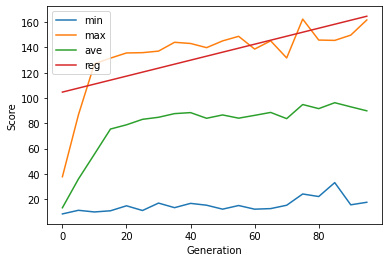

In [19]:
renge=100
step=5
ends = (renge//step)

mi = np.zeros(ends)
ma = np.zeros(ends)
av = np.zeros(ends)
end=0
for file in files:
    _mi, _ma, _av, end = log_load(file,task, renge=renge, _step=step)
    assert _mi.size==mi.size, f'{file} {_mi.size} dont match'
    mi=np.add(mi,_mi)
    ma=np.add(ma,_ma)
    av=np.add(av,_av)
mi=np.divide(mi,10)
ma=np.divide(ma,10)
av=np.divide(av,10)
ge = np.arange((ends-mi.size)*step, ends*step, step)

a,b=np.polyfit(ge,ma,1)
fh=a*ge+b
print(a)
title = f"./results/tpg-mh-{task.replace('/','-')}"
plt.plot(ge, mi, label='min')
plt.plot(ge, ma, label='max')
plt.plot(ge, av, label='ave')
plt.plot(ge, fh, label='reg')

plt.ylabel('Score')
plt.xlabel('Generation')
plt.legend()
plt.savefig(f"{title}.png")
plt.show()
with open(f'{title}.txt','w') as f:
    f.write(f'min-min:{min(mi)}, max-min:{min(ma)}, ave-min:{min(av)}, min-max:{max(mi)}, max-max:{max(ma)}, ave-max:{max(av)}, min-ave:{sum(mi)/len(mi)}, max-ave:{sum(ma)/len(ma)}, ave-ave:{sum(av)/len(av)}, fh-a:{a}, fh-b:{b}')


### Emulator

#### CartPole-v1

In [20]:
prefix = './log/CartPole-v1/2022-12-16/'
files = [
    f'{prefix}14-46-27',
    f'{prefix}14-49-00',
    f'{prefix}14-49-13',
    f'{prefix}14-49-29',
    f'{prefix}14-49-39',
    f'{prefix}14-49-55',
    f'{prefix}14-50-05',
    f'{prefix}14-50-16',
    f'{prefix}14-50-27',
    f'{prefix}14-50-53'
]
task="CartPole-v1"

#### Show

-0.019299897086026828


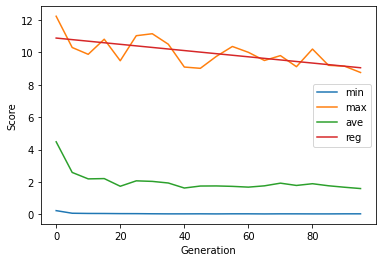

-2.887268074419482


In [21]:
renge=100
step=5
ends = (renge//step)

mi = np.zeros(ends)
ma = np.zeros(ends)
av = np.zeros(ends)
end=0
for file in files:
    _mi, _ma, _av, end = log_load(file,task, renge=renge, _step=step)
    assert _mi.size==mi.size, f'{file} {_mi.size} dont match'
    mi=np.add(mi,_mi)
    ma=np.add(ma,_ma)
    av=np.add(av,_av)
mi=np.divide(mi,10)
ma=np.divide(ma,10)
av=np.divide(av,10)
ge = np.arange((ends-mi.size)*step, ends*step, step)

a,b=np.polyfit(ge,ma,1)
fh=a*ge+b
print(a,b)
title = f"./results/tpg-emulator-{task.replace('/','-')}"
plt.plot(ge, mi, label='min')
plt.plot(ge, ma, label='max')
plt.plot(ge, av, label='ave')
plt.plot(ge, fh, label='reg')

plt.ylabel('Score')
plt.xlabel('Generation')
plt.legend()
plt.savefig(f"{title}.png")
plt.show()
with open(f'{title}.txt','w') as f:
    f.write(f'min-min:{min(mi)}, max-min:{min(ma)}, ave-min:{min(av)}, min-max:{max(mi)}, max-max:{max(ma)}, ave-max:{max(av)}, min-ave:{sum(mi)/len(mi)}, max-ave:{sum(ma)/len(ma)}, ave-ave:{sum(av)/len(av)}, fh-a:{a}, fh-b:{b}')
print(av[-1]-av[0])

### Actor

#### CartPole-v1

In [24]:
prefix = './log/CartPole-v1/2022-12-07/'
files = [
    f'{prefix}16-45-34',
    f'{prefix}16-45-04',
    f'{prefix}16-44-32',
    f'{prefix}16-42-52',
    f'{prefix}16-42-24',
    f'{prefix}16-40-43',
    f'{prefix}16-40-03',
    f'{prefix}16-39-53',
    f'{prefix}16-39-12',
    f'{prefix}16-38-44'
]
task="CartPole-v1"

#### Show

0.8274857142857143


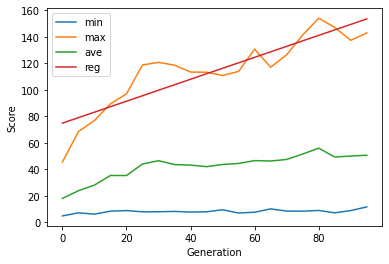

32.592909090909096


In [25]:
renge=100
step=5
ends = (renge//step)

mi = np.zeros(ends)
ma = np.zeros(ends)
av = np.zeros(ends)
end=0
for file in files:
    _mi, _ma, _av, end = log_load(file,task, renge=renge, _step=step)
    assert _mi.size==mi.size, f'{file} {_mi.size} dont match'
    mi=np.add(mi,_mi)
    ma=np.add(ma,_ma)
    av=np.add(av,_av)
mi=np.divide(mi,10)
ma=np.divide(ma,10)
av=np.divide(av,10)
ge = np.arange((ends-mi.size)*step, ends*step, step)

a,b=np.polyfit(ge,ma,1)
fh=a*ge+b
print(a, b)
title = f"./results/tpg-actor-{task.replace('/','-')}"
plt.plot(ge, mi, label='min')
plt.plot(ge, ma, label='max')
plt.plot(ge, av, label='ave')
plt.plot(ge, fh, label='reg')

plt.ylabel('Score')
plt.xlabel('Generation')
plt.legend()
plt.savefig(f"{title}.png")
plt.show()
with open(f'{title}.txt','w') as f:
    f.write(f'min-min:{min(mi)}, max-min:{min(ma)}, ave-min:{min(av)}, min-max:{max(mi)}, max-max:{max(ma)}, ave-max:{max(av)}, min-ave:{sum(mi)/len(mi)}, max-ave:{sum(ma)/len(ma)}, ave-ave:{sum(av)/len(av)}, fh-a:{a}, fh-b:{b}')
print(av[-1]-av[0])

# multi elite

In [186]:
prefix_results = './results/'
normalize_file = {
    'ALE/Jamesbond-ram-v5': f'{prefix_results}tpg-ALE-Jamesbond-ram-v5', 
    'ALE/Pitfall-ram-v5': f'{prefix_results}tpg-ALE-Pitfall-ram-v5', 
    'ALE/WizardOfWor-v5': f'{prefix_results}tpg-ALE-WizardOfWor-v5', 
    'DoubleDunk-ramNoFrameskip-v4': f'{prefix_results}tpg-DoubleDunk-ramNoFrameskip-v4', 
    'Hero-ramDeterministic-v4': f'{prefix_results}tpg-Hero-ramDeterministic-v4', 
    'Hero-v4': f'{prefix_results}tpg-Hero-v4', 
    'MontezumaRevengeDeterministic-v0': f'{prefix_results}tpg-MontezumaRevengeDeterministic-v0', 
    'PitfallDeterministic-v4': f'{prefix_results}tpg-PitfallDeterministic-v4',
    'PrivateEye-ramDeterministic-v0': f'{prefix_results}tpg-PrivateEye-ramDeterministic-v0', 
    'SpaceInvaders-v0': f'{prefix_results}tpg-SpaceInvaders-v0'
}

In [215]:
prefix_results = './results/'
normalize_file = {
    'ALE/Jamesbond-ram-v5': f'{prefix_results}tpg-mh-ALE-Jamesbond-ram-v5', 
    'ALE/Pitfall-ram-v5': f'{prefix_results}tpg-mh-ALE-Pitfall-ram-v5', 
    'ALE/WizardOfWor-v5': f'{prefix_results}tpg-mh-ALE-WizardOfWor-v5', 
    'DoubleDunk-ramNoFrameskip-v4': f'{prefix_results}tpg-mh-DoubleDunk-ramNoFrameskip-v4', 
    'Hero-ramDeterministic-v4': f'{prefix_results}tpg-mh-Hero-ramDeterministic-v4', 
    'Hero-v4': f'{prefix_results}tpg-mh-Hero-v4', 
    'MontezumaRevengeDeterministic-v0': f'{prefix_results}tpg-mh-MontezumaRevengeDeterministic-v0', 
    'PitfallDeterministic-v4': f'{prefix_results}tpg-mh-PitfallDeterministic-v4',
    'PrivateEye-ramDeterministic-v0': f'{prefix_results}tpg-mh-PrivateEye-ramDeterministic-v0', 
    'SpaceInvaders-v0': f'{prefix_results}tpg-mh-SpaceInvaders-v0'
}


In [216]:
ignores = [
    # 'Hero-v4', 
    # 'Hero-ramDeterministic-v4'
]
normalize = {}
scores_tpg = {}
scores_tpg_mh = {}
scores_tpg_actor2 = {}

# _type='ave'
for task, file in normalize_file.items():
    normal = log_normalize(file, _min_type='min', _max_type='max')
    scores_tpg[task]=0.
    scores_tpg_mh[task]=0.
    scores_tpg_actor2[task]=0.
    # print(task, normalize)
    normalize[task]=normal
normalize

{'ALE/Jamesbond-ram-v5': [0.0, 106.0],
 'ALE/Pitfall-ram-v5': [-88.14, 0.0],
 'ALE/WizardOfWor-v5': [32.0, 200.0],
 'DoubleDunk-ramNoFrameskip-v4': [-0.4800000000000001, 0.2],
 'Hero-ramDeterministic-v4': [0.0, 346.9],
 'Hero-v4': [0.0, 7.5],
 'MontezumaRevengeDeterministic-v0': [0.0, 0.0],
 'PitfallDeterministic-v4': [-122.64000000000001, 0.0],
 'PrivateEye-ramDeterministic-v0': [-713.4600000000002, 43.72],
 'SpaceInvaders-v0': [29.9, 250.0]}

### TPG

In [265]:
import _tpg.tpg as tp
prefix = '/Users/matsuzawakazuki/Downloads/test/'
graphs = [
    f'{prefix}2022-12-06/16-20-12',
    f'{prefix}2022-12-06/17-02-25',
    f'{prefix}2022-12-06/17-44-30',
    f'{prefix}2022-12-06/18-58-52',
    f'{prefix}2022-12-06/19-52-11',
    f'{prefix}2022-12-06/20-29-42',
    f'{prefix}2022-12-06/21-29-47',
    f'{prefix}2022-12-06/22-21-45',
    f'{prefix}2022-12-06/23-10-06',
    f'{prefix}2022-12-06/23-55-21'
]
tpg = tp._TPG()

In [83]:
prefix = './log/test/'
titles = [
    f'{prefix}2022-12-09/19-34-29',
    f'{prefix}2022-12-09/19-36-00',
    f'{prefix}2022-12-09/19-36-15',
    f'{prefix}2022-12-09/19-36-35',
    f'{prefix}2022-12-09/19-37-07',
    f'{prefix}2022-12-09/19-37-22',
    f'{prefix}2022-12-09/19-37-38',
    f'{prefix}2022-12-09/19-38-06',
    f'{prefix}2022-12-09/19-38-25',
    f'{prefix}2022-12-09/19-38-41'
]

#### random

In [ ]:
prefix = '../../../Downloads/test/'
graphs = [
    f'{prefix}2022-12-02/20-51-19'
]
tpg = tp.MHTPG()

for graph in graphs:
    title = test_multi_elite()

#### chaos

In [217]:
prefix = './log/test/'
titles = [
    f'{prefix}2022-12-11/19-58-55',
    f'{prefix}2022-12-11/19-59-12',
    f'{prefix}2022-12-11/19-59-27',
    f'{prefix}2022-12-11/19-59-41',
    f'{prefix}2022-12-11/20-00-23',
    f'{prefix}2022-12-11/20-00-50',
    f'{prefix}2022-12-11/20-01-10',
    f'{prefix}2022-12-11/20-01-24',
    f'{prefix}2022-12-11/20-03-00',
    f'{prefix}2022-12-11/20-03-14'
]

In [218]:

for title in titles:
    scores_tpg = log_elite(title, _scores=scores_tpg)
print(repr(scores_tpg))
for ignore in ignores:
    del scores_tpg[ignore]
for task in scores_tpg:
    # normalize = log_normalize(normalize_file[task])
    scores_tpg[task]= (scores_tpg[task]-normalize[task][0])/(normalize[task][1]-normalize[task][0]+0.00001)*10.0
scores_tpg

{'ALE/Jamesbond-ram-v5': 150.0, 'ALE/Pitfall-ram-v5': -72.0, 'ALE/WizardOfWor-v5': 2000.0, 'DoubleDunk-ramNoFrameskip-v4': 4.0, 'Hero-ramDeterministic-v4': 75.0, 'Hero-v4': 0.0, 'MontezumaRevengeDeterministic-v0': 0.0, 'PitfallDeterministic-v4': 0.0, 'PrivateEye-ramDeterministic-v0': -2190.0, 'SpaceInvaders-v0': 2090.0}


{'ALE/Jamesbond-ram-v5': 14.15094206123188,
 'ALE/Pitfall-ram-v5': 1.831177464127812,
 'ALE/WizardOfWor-v5': 117.14285017006844,
 'DoubleDunk-ramNoFrameskip-v4': 65.88138409729268,
 'Hero-ramDeterministic-v4': 2.162006279561653,
 'Hero-v4': 0.0,
 'MontezumaRevengeDeterministic-v0': 0.0,
 'PitfallDeterministic-v4': 9.999999184605414,
 'PrivateEye-ramDeterministic-v0': -19.500514811530746,
 'SpaceInvaders-v0': 93.59836012728941}

### MHTPG

In [267]:
prefix = '../../../Downloads/test/'
graphs = [
    f'{prefix}2022-12-05/13-33-02',
    f'{prefix}2022-12-04/03-06-27',
    f'{prefix}2022-12-04/07-02-08',
    f'{prefix}2022-12-04/10-01-16',
    f'{prefix}2022-12-04/13-43-48',
    f'{prefix}2022-12-04/14-57-20',
    f'{prefix}2022-12-04/17-12-37',
    f'{prefix}2022-12-04/20-56-58',
    f'{prefix}2022-12-04/20-59-14',
    f'{prefix}2022-12-04/23-32-04'
]
tpg = tp.MHTPG()

In [58]:
prefix = './log/test/'
titles = [
    f'{prefix}2022-12-09/19-43-07',
    f'{prefix}2022-12-09/19-43-32',
    f'{prefix}2022-12-09/19-43-54',
    f'{prefix}2022-12-09/19-44-11',
    f'{prefix}2022-12-09/19-44-31',
    f'{prefix}2022-12-09/19-44-47',
    f'{prefix}2022-12-09/19-45-01',
    f'{prefix}2022-12-09/19-45-16',
    f'{prefix}2022-12-09/19-45-31',
    f'{prefix}2022-12-09/19-45-45'
]

#### random

In [ ]:
prefix = '../../../Downloads/test/'
graphs = [
    f'{prefix}2022-12-02/20-51-19'
]
tpg = tp.MHTPG()

for graph in graphs:
    title = test_multi_elite()

#### chaos

In [219]:
prefix = './log/test/'
titles = [
    f'{prefix}2022-12-11/20-04-02',
    f'{prefix}2022-12-11/20-04-19',
    f'{prefix}2022-12-11/20-04-41',
    f'{prefix}2022-12-11/20-05-00',
    f'{prefix}2022-12-11/20-05-19',
    f'{prefix}2022-12-11/20-05-38',
    f'{prefix}2022-12-11/20-05-57',
    f'{prefix}2022-12-11/20-06-13',
    f'{prefix}2022-12-11/20-06-32',
    f'{prefix}2022-12-11/20-07-26'
]

In [220]:

for title in titles:
    scores_tpg_mh = log_elite(title, _scores=scores_tpg_mh)

for task in scores_tpg_mh:
    # normalize = log_normalize(normalize_file[task])
    scores_tpg_mh[task]= (scores_tpg_mh[task]-normalize[task][0])/(normalize[task][1]-normalize[task][0]+0.00001)*10.0
print(scores_tpg_mh)
for ignore in ignores:
    del scores_tpg_mh[ignore]
scores_tpg_mh

{'ALE/Jamesbond-ram-v5': 18.867922748309173, 'ALE/Pitfall-ram-v5': 9.999998865441471, 'ALE/WizardOfWor-v5': 111.19046957199586, 'DoubleDunk-ramNoFrameskip-v4': 124.70404846987543, 'Hero-ramDeterministic-v4': 82.87690738319668, 'Hero-v4': 199.99973333368888, 'MontezumaRevengeDeterministic-v0': 0.0, 'PitfallDeterministic-v4': 9.999999184605414, 'PrivateEye-ramDeterministic-v0': -33.01117260081918, 'SpaceInvaders-v0': 94.50703795969841}


{'ALE/Jamesbond-ram-v5': 18.867922748309173,
 'ALE/Pitfall-ram-v5': 9.999998865441471,
 'ALE/WizardOfWor-v5': 111.19046957199586,
 'DoubleDunk-ramNoFrameskip-v4': 124.70404846987543,
 'Hero-ramDeterministic-v4': 82.87690738319668,
 'Hero-v4': 199.99973333368888,
 'MontezumaRevengeDeterministic-v0': 0.0,
 'PitfallDeterministic-v4': 9.999999184605414,
 'PrivateEye-ramDeterministic-v0': -33.01117260081918,
 'SpaceInvaders-v0': 94.50703795969841}

### Actor1

In [269]:
prefix = '../../../Downloads/test/'
graphs = [
    f'{prefix}2022-12-06/',
    f'{prefix}2022-12-06/',
    f'{prefix}2022-12-06/',
    f'{prefix}2022-12-06/',
    f'{prefix}2022-12-06/',
    f'{prefix}2022-12-06/',
    f'{prefix}2022-12-06/',
    f'{prefix}2022-12-06/',
    f'{prefix}2022-12-06/',
    f'{prefix}2022-12-06/'
]
tpg = tp.Actor1()

### Actor2

In [487]:
prefix = './log/test/'
graphs = [
    f'{prefix}2022-12-06/20-31-12',
    f'{prefix}2022-12-06/23-15-46',
    f'{prefix}2022-12-07/02-15-56',
    f'{prefix}2022-12-07/04-24-40',
    f'{prefix}2022-12-07/07-25-56',
    f'{prefix}2022-12-07/09-08-15',
    f'{prefix}2022-12-07/12-13-30',
    f'{prefix}2022-12-07/23-08-26',
    f'{prefix}2022-12-08/02-16-43',
    f'{prefix}2022-12-08/04-13-09'
]
tpg = tp.Actor2()

In [60]:
prefix = './log/test/'
titles = [
    f'{prefix}2022-12-09/19-55-51',
    f'{prefix}2022-12-09/19-56-15',
    f'{prefix}2022-12-09/19-56-35',
    f'{prefix}2022-12-09/19-56-53',
    f'{prefix}2022-12-09/19-57-13',
    f'{prefix}2022-12-09/19-57-30',
    f'{prefix}2022-12-09/19-57-52',
    f'{prefix}2022-12-09/19-58-23',
    f'{prefix}2022-12-09/19-59-05',
    f'{prefix}2022-12-09/19-59-24'
]

#### chaos

In [221]:
prefix = './log/test/'
titles = [
    f'{prefix}2022-12-11/20-15-07',
    f'{prefix}2022-12-11/20-15-23',
    f'{prefix}2022-12-11/20-15-43',
    f'{prefix}2022-12-11/20-16-00',
    f'{prefix}2022-12-11/20-16-16',
    f'{prefix}2022-12-11/20-16-32',
    f'{prefix}2022-12-11/20-16-53',
    f'{prefix}2022-12-11/20-17-13',
    f'{prefix}2022-12-11/20-17-44',
    f'{prefix}2022-12-11/20-17-59'
]
prefix = './log/test/'
titles = [
    f'{prefix}2022-12-19/05-17-47',
    f'{prefix}2022-12-19/05-18-55',
    f'{prefix}2022-12-19/05-19-15',
    f'{prefix}2022-12-19/05-19-54',
    f'{prefix}2022-12-19/05-20-14',
    f'{prefix}2022-12-19/05-27-13',
    f'{prefix}2022-12-19/05-27-28',
    f'{prefix}2022-12-19/05-27-47',
    f'{prefix}2022-12-19/05-28-05',
    f'{prefix}2022-12-19/05-28-21'
]


In [222]:

for title in titles:
    scores_tpg_actor2 = log_elite(title, _scores=scores_tpg_actor2)

for task in scores_tpg_actor2:
    scores_tpg_actor2[task]= (scores_tpg_actor2[task]-normalize[task][0])/(normalize[task][1]-normalize[task][0]+0.00001)*10.0
print(scores_tpg_actor2)
for ignore in ignores:
    del scores_tpg_actor2[ignore]
scores_tpg_actor2

{'ALE/Jamesbond-ram-v5': 28.30188412246376, 'ALE/Pitfall-ram-v5': 9.999998865441471, 'ALE/WizardOfWor-v5': 81.42856658163295, 'DoubleDunk-ramNoFrameskip-v4': 65.88138409729268, 'Hero-ramDeterministic-v4': 82.01210487137203, 'Hero-v4': 3693.3284088954547, 'MontezumaRevengeDeterministic-v0': 0.0, 'PitfallDeterministic-v4': 9.999999184605414, 'PrivateEye-ramDeterministic-v0': 1.5248685712133383, 'SpaceInvaders-v0': 97.00590199882316}


{'ALE/Jamesbond-ram-v5': 28.30188412246376,
 'ALE/Pitfall-ram-v5': 9.999998865441471,
 'ALE/WizardOfWor-v5': 81.42856658163295,
 'DoubleDunk-ramNoFrameskip-v4': 65.88138409729268,
 'Hero-ramDeterministic-v4': 82.01210487137203,
 'Hero-v4': 3693.3284088954547,
 'MontezumaRevengeDeterministic-v0': 0.0,
 'PitfallDeterministic-v4': 9.999999184605414,
 'PrivateEye-ramDeterministic-v0': 1.5248685712133383,
 'SpaceInvaders-v0': 97.00590199882316}

### Show

28.52662045726466 61.913494491599224 406.94831171882987


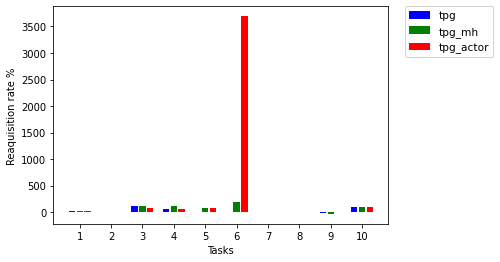

In [223]:
left = np.arange(1, len(scores_tpg.keys())+1)
labels = [str(i) for i in left]
width = 0.2
edges = [0+0.5, len(scores_tpg.keys())+0.5]
plt.bar(left-0.25, scores_tpg.values(), width=width, color="blue", label='tpg')
plt.bar(left, scores_tpg_mh.values(), width=width, color="green", label='tpg_mh')
plt.bar(left+0.25, scores_tpg_actor2.values(), width=width, color="red", label='tpg_actor')
# plt.plot(edges, [sum(scores_tpg.values())/10.]*len(edges), label='tpg-ave', c="royalblue")
# plt.plot(edges, [sum(scores_tpg_mh.values())/10.]*len(edges), label='tpg_mh-ave', c="lime")
# plt.plot(edges, [sum(scores_tpg_actor2.values())/10.]*len(edges), label='tpg_actor-ave', c="tomato")
plt.xticks(left, labels)
# plt.suptitle('Categorical Plotting')
plt.xlabel('Tasks')
plt.ylabel('Reaquisition rate %')

# plt.title('Multi-Task Scores')
# plt.legend()
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=10.5)
print(sum(scores_tpg.values())/10.,sum(scores_tpg_mh.values())/10.,sum(scores_tpg_actor2.values())/10.)
# plt.savefig()
plt.show()
# multi-10-tasks: 394.45354363594583 7500218.961637132 546500433.9280788
# multi-9-tasks: 394.45354363594583 218.9616371318259 433.92807890293545
# multi-8-tasks: 28.453787635783165 27.628431353963087 30.59501445831173
# multi-mh-tasks: 45.9181633364101 47.57909559132741 780.5565959715974
# multi-mh-9-tasks: 45.9181633364101 37.579108924642966 51.890900859190914
# chaos-10: 30.475905076862755 15000219.657665115 277000216.52672666
# chaos-9: 30.475905076862755 219.65766511934117 216.52672667207617
# chaos-8: 25.475908410193867 27.99112623036706 26.860186449769582
# chaos-mh-10: 28.52662045726466 61.913494491599224 406.94831171882987
# chaos-mh-9: 28.52662045726466 41.91352115823033 37.61547082928448

In [1]:
import gym
env = gym.make('CartPole-v0')
env.reset()
env.render(mode='rgb_array')
env.close()

: 